In [71]:
# from pycirclize import Circos
# from pycirclize.utils import ColorCycler
# import numpy as np
# np.random.seed(0)

# sectors = {"A": 10, "B": 20, "C": 15}
# circos = Circos(sectors, space=5)
# for sector in circos.sectors:
#     vmin, vmax = 1, 10
#     x = np.linspace(sector.start + 0.5, sector.end - 0.5, int(sector.size))
#     y = np.random.randint(vmin, vmax, len(x))
#     # Plot bar (default)
#     track1 = sector.add_track((80, 100), r_pad_ratio=0.1)
#     track1.axis()
#     track1.xticks_by_interval(1)
#     track1.xticks_by_interval(0.1, tick_length=1, show_label=False)
#     track1.bar(x, y)
#     # Plot stacked bar with user-specified params
#     track2 = sector.add_track((50, 70))
#     track2.axis()
#     track2.xticks_by_interval(1, outer=False)

#     ColorCycler.set_cmap("tab10")
#     tab10_colors = [ColorCycler() for _ in range(len(x))]
#     track2.bar(x, y, width=1.0, color=tab10_colors, ec="grey", lw=0.5, vmax=vmax * 2)

#     ColorCycler.set_cmap("Pastel1")
#     pastel_colors = [ColorCycler() for _ in range(len(x))]
#     y2 = np.random.randint(vmin, vmax, len(x))
#     track2.bar(x, y2, width=1.0, bottom=y, color=pastel_colors, ec="grey", lw=0.5, hatch="//", vmax=vmax * 2)

# fig = circos.plotfig()

In [6]:
import pandas as pd
import numpy as np
from pycirclize import Circos
from pycirclize.utils import ColorCycler
import matplotlib.pyplot as plt
import numpy as np

# 加载circRNA序列
csv_path = "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/archived/circExor_archived_2025_5/sample_preprocessing/circRNA/output_with_sequences.csv"
df = pd.read_csv(csv_path, sep = '\t')
df = df[df['Sequence'] != 'Sequence_not_found']
# 提取序列列
sequences = df["Sequence"].dropna()

# 指定的20个kmer
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
cyto_kmers = ['AGT', 'TCTAG', 'TACAG', 'CGCA', 'ATAA', 'GTGA', 'GACC', 'TGGC', 'AACTT']
all_kmers = ev_kmers + cyto_kmers

# 初始化参数
num_bins = 100
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in all_kmers}

In [2]:
# 统计每个kmer在所有序列中每个bin内的出现次数
for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, all_kmers))]  # 环形拼接
    for kmer in all_kmers:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

In [3]:
# 归一化为平均每个序列上的频率
for kmer in all_kmers:
    kmer_bin_counts[kmer] = kmer_bin_counts[kmer] / len(sequences)
# 准备数据用于堆叠柱状图绘制
bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in all_kmers])  # shape: (20, 100)
x = np.arange(num_bins)
stack_bottom = np.zeros(num_bins)

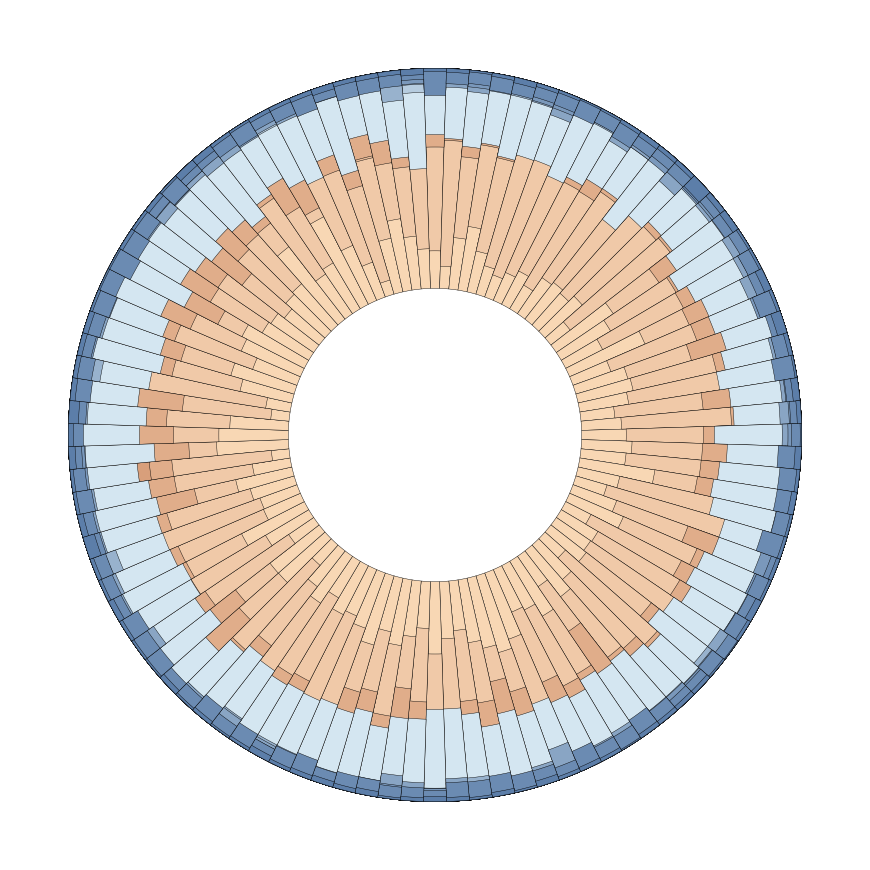

In [21]:
# 环形图构建
circos1 = Circos(sectors={"circRNA": num_bins})
sector = circos1.sectors[0]
track = sector.add_track((40, 100))

warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
]
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]
colors = warm_colors + cool_colors

cum = np.cumsum(bin_matrix, axis=0)              # shape (20, num_bins)
bottoms = np.vstack([np.zeros(num_bins), cum[:-1]])  # bottoms[i] is the bottom for layer i

for j in range(num_bins):
    bottom = 0.0
    xj = np.array([x[j]])
    for i in range(len(all_kmers)):
        hj = np.array([bin_matrix[i, j]])
        if hj[0] <= 0:
            continue
        track.bar(
            xj,
            hj,
            bottom=np.array([bottom]),
            width=1.0,
            color=colors[i],
            ec="black",      # 黑色边线
            lw=0.3,          # 细线
            antialiased=True, # 开启抗锯齿
            zorder=i
        )
        bottom += hj[0]


# 输出图形
fig = circos1.plotfig()
plt.show()

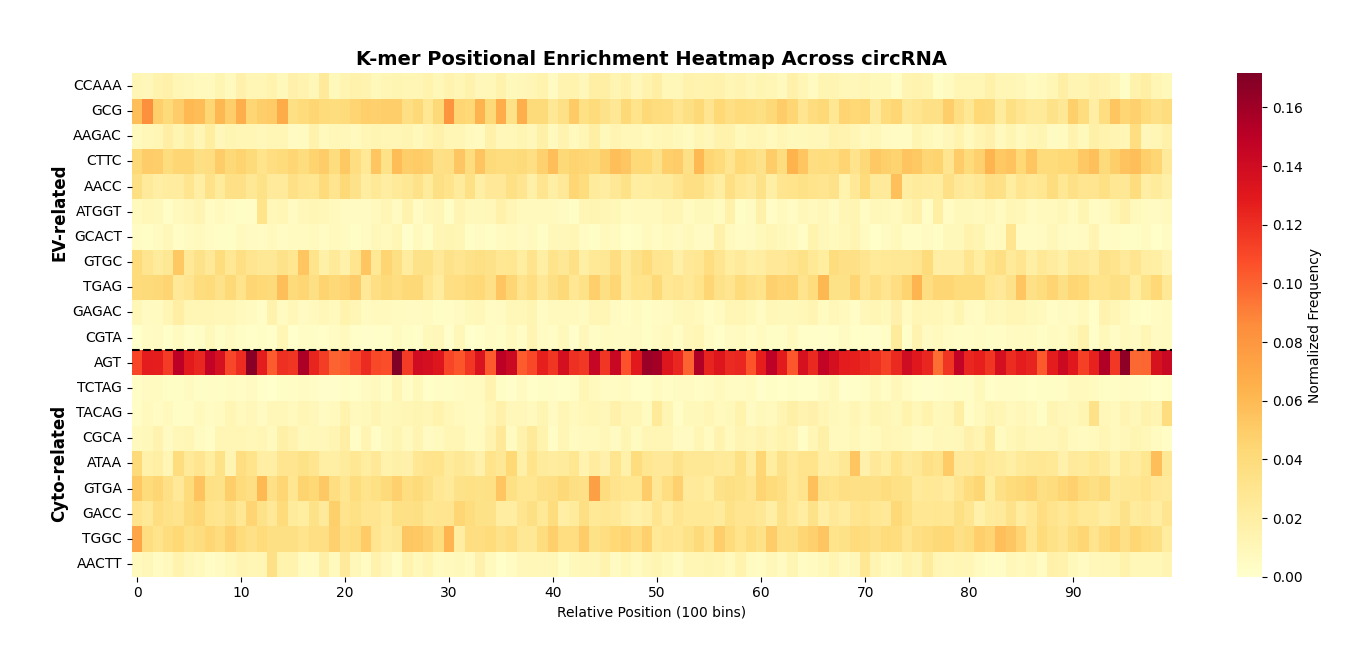

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 组别信息
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
cyto_kmers = ['AGT', 'TCTAG', 'TACAG', 'CGCA', 'ATAA', 'GTGA', 'GACC', 'TGGC', 'AACTT']
all_kmers = ev_kmers + cyto_kmers

# 绘制热图
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    bin_matrix,
    cmap="YlOrRd",
    xticklabels=10,
    yticklabels=all_kmers,
    cbar_kws={'label': 'Normalized Frequency'}
)

# 添加分组分隔线（EV 组在前 11 行，Cyto 组在后 9 行）
ev_count = len(ev_kmers)
ax.hlines(ev_count, *ax.get_xlim(), colors='black', linestyles='dashed', linewidth=1.5)

# 添加组别标签
plt.text(
    -7, ev_count / 2, "EV-related", rotation=90, va='center', ha='center', fontsize=12, fontweight='bold'
)
plt.text(
    -7, ev_count + (len(cyto_kmers) / 2), "Cyto-related", rotation=90, va='center', ha='center', fontsize=12, fontweight='bold'
)

plt.title("K-mer Positional Enrichment Heatmap Across circRNA", fontsize=14, fontweight='bold')
plt.xlabel("Relative Position (100 bins)")
# plt.ylabel("K-mer")
plt.tight_layout()
plt.show()


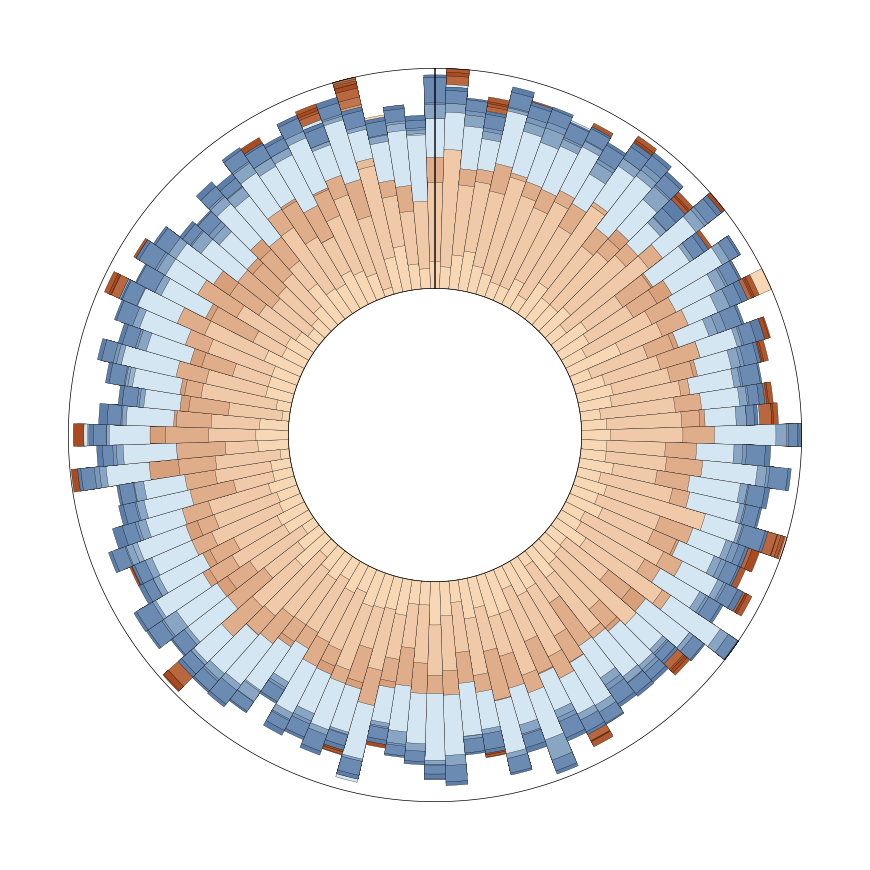

In [7]:
# 环形图构建
circos1 = Circos(sectors={"circRNA": num_bins})
sector = circos1.sectors[0]
track = sector.add_track((40, 100))
track.axis()


warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
]
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]
colors = warm_colors + cool_colors

# 重置堆积底部高度
stack_bottom = np.zeros(num_bins)

for i in range(len(all_kmers)):
    track.bar(
        x,
        bin_matrix[i],
        bottom=stack_bottom,
        width=1.0,
        color=colors[i],
        ec="black",
        lw=0.2
    )
    stack_bottom += bin_matrix[i]

# 输出图形
fig = circos1.plotfig()
plt.show()


In [1]:
import matplotlib.pyplot as plt

# ===== 输入数据 =====
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
] 

cyto_kmers = ['AGT', 'TCTAG', 'TACAG', 'CGCA', 'ATAA', 'GTGA', 'GACC', 'TGGC', 'AACTT'] 
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]

# ===== 公共绘图函数 =====
def plot_kmer_legend(kmers, colors, filename, labelspacing=0.6, markersize=10, figsize=(2, 6)):
    """
    绘制 k-mer 与颜色对应的图例，并保存为透明背景图片
    """
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=figsize)

    handles = []
    for kmer, color in zip(kmers, colors):
        patch = plt.Line2D(
            [0], [0], marker='s', color='w', label=kmer,
            markerfacecolor=color, markersize=markersize
        )
        handles.append(patch)

    legend = ax.legend(
        handles=handles,
        labels=kmers,
        loc='center',
        ncol=1,
        frameon=False,
        labelspacing=labelspacing  # 控制行间距
    )
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

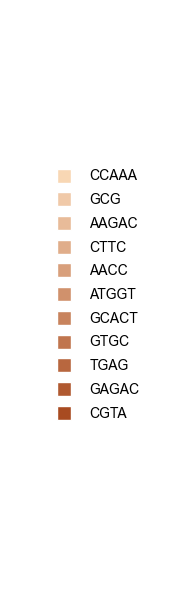

In [2]:
plot_kmer_legend(ev_kmers, warm_colors, "legend_ev.png", labelspacing=0.7)

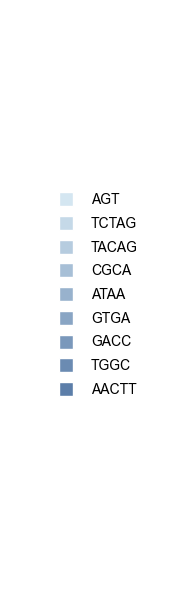

In [3]:
plot_kmer_legend(cyto_kmers, cool_colors, "legend_cyto.png", labelspacing=0.7)

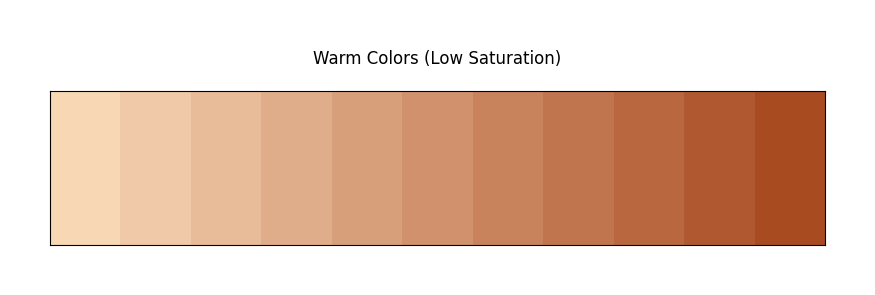

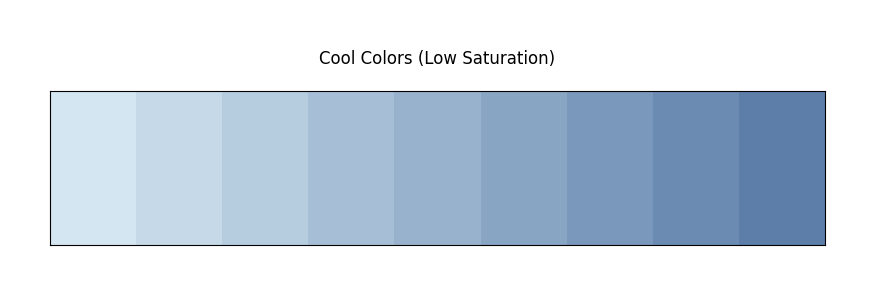

In [77]:
warm_colors = [
    '#F8D7B4',  # 浅杏色 (Light Apricot)
    '#F0C9A8',  # 沙色 (Sand)
    '#E8BB99',  # 陶土色 (Terracotta)
    '#E0AD8A',  # 灰粉色 (Dusty Pink)
    '#D89F7B',  # 黏土色 (Clay)
    '#D0916C',  # 肉桂色 (Cinnamon)
    '#C8835D',  # 赤陶色 (Red Clay)
    '#C0754E',  # 锈色 (Rust)
    '#B8673F',  # 赭石色 (Ochre)
    '#B05930',  # 深陶色 (Deep Terracotta)
    '#A84B21'   # 砖红色 (Brick Red)
]

cool_colors = [
    '#D4E6F1',  # 雾蓝色 (Mist Blue)
    '#C5D9E8',  # 灰蓝色 (Grayish Blue)
    '#B6CCDF',  # 钢蓝色 (Steel Blue)
    '#A7BFD6',  # 灰蓝 (Slate Blue)
    '#98B2CD',  # 冷蓝色 (Cool Blue)
    '#89A5C4',  # 蓝灰色 (Blue Gray)
    '#7A98BB',  # 灰蓝 (Dusty Blue)
    '#6B8BB2',  # 深灰蓝 (Deep Gray Blue)
    '#5C7EA9'   # 暗蓝色 (Dark Muted Blue)
]

import matplotlib.pyplot as plt
import numpy as np

def plot_colors(colors, title):
    fig, ax = plt.subplots(figsize=(10, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, pad=20)
    plt.show()

plot_colors(warm_colors, "Warm Colors (Low Saturation)")
plot_colors(cool_colors, "Cool Colors (Low Saturation)")

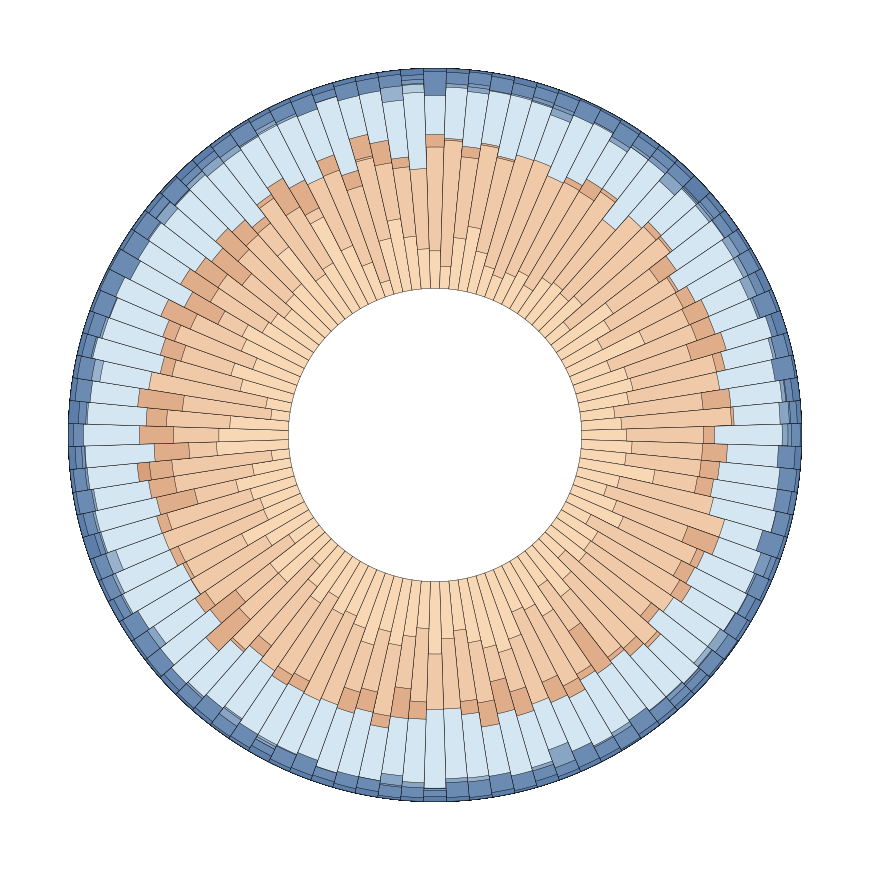

In [29]:
import pandas as pd
import numpy as np
from pycirclize import Circos
import matplotlib.pyplot as plt

# 加载circRNA序列
csv_path = "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/archived/circExor_archived_2025_5/sample_preprocessing/circRNA/output_with_sequences.csv"
df = pd.read_csv(csv_path, sep='\t')
df = df[df['Sequence'] != 'Sequence_not_found']
sequences = df["Sequence"].dropna()

# 20个kmer
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
cyto_kmers = ['AGT', 'TCTAG', 'TACAG', 'CGCA', 'ATAA', 'GTGA', 'GACC', 'TGGC', 'AACTT']
all_kmers = ev_kmers + cyto_kmers

# 初始化统计矩阵
num_bins = 100
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in all_kmers}

# 统计每个bin的kmer频率
for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, all_kmers))]  # 环形拼接
    for kmer in all_kmers:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

# 归一化为平均频率
for kmer in all_kmers:
    kmer_bin_counts[kmer] /= len(sequences)

# 构建矩阵 (20, num_bins)
bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in all_kmers])

# ===== 百分比堆积归一化 =====
bin_sums = bin_matrix.sum(axis=0, keepdims=True)
# 避免除以0
bin_sums[bin_sums == 0] = 1
bin_matrix = bin_matrix / bin_sums

# ===== 绘制环形图 =====
circos1 = Circos(sectors={"circRNA": num_bins})
sector = circos1.sectors[0]
track = sector.add_track((40, 100))  # 半径范围

# 颜色
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
]
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]
colors = warm_colors + cool_colors

# 绘制堆积柱状
x = np.arange(num_bins)
for j in range(num_bins):
    bottom = 0.0
    xj = np.array([x[j]])
    for i in range(len(all_kmers)):
        hj = np.array([bin_matrix[i, j]])
        track.bar(
            xj,
            hj,
            bottom=np.array([bottom]),
            width=1.0,
            color=colors[i],
            ec="black",
            lw=0.3,
            antialiased=True,
            zorder=i
        )
        bottom += hj[0]

# ===== 添加百分比纵坐标刻度 =====
# 刻度值 0%, 25%, 50%, 75%, 100%
percent_ticks = np.linspace(0, 1, 5)
# track.axis(
#     rlim=(0, 1),
#     rticks=percent_ticks,
#     show=True,
#     tick_labels=[f"{int(p*100)}%" for p in percent_ticks],
#     lw=0.5,
#     label_size=8
# )

# 输出图形
fig = circos1.plotfig()
plt.show()
